In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import networkx as nx
import re

## 10개 이하 등장 앱 제거

In [28]:
df = pd.read_csv('Sorted_App_Data.csv')

In [29]:
len(df)

115373

In [30]:
# 'app' 열을 리스트로 변환
df['app'] = df['app'].str.strip('[]').str.replace(' ', '').str.split(',')

# 각 앱의 등장 빈도 계산
app_counts = Counter(app for apps in df['app'] for app in apps)

# 10번 이하로 등장하는 앱 식별
rare_apps = {app for app, count in app_counts.items() if count <= 10}

# 적게 등장하는 앱이 포함된 행 제거
df['app'] = df['app'].apply(lambda x: [app for app in x if app not in rare_apps])

# 빈 리스트가 된 행 제거
df = df[df['app'].apply(len) > 0]

# 결과 확인

print(df)

        Unnamed: 0                                               adid  \
0                0  000a50b7b4d0fdb6491ab9a2351d1bb172dbd55c8bcbee...   
1                1  0015097393e6d38fc8184e95be0fa9264a717dcca15317...   
2                2  001cf1c5d0b5370c962db73791bb3633391abe6d8fe790...   
3                3  002370c782d8c493ac183c2ac36a9479ba80fc7b6668d9...   
4                4  0026958c739af193711278a28b1b8910bf38c1caf7393e...   
...            ...                                                ...   
115368       46774  ffedd506b908b1ec6c6315f239f12c1375280a6b879eb4...   
115369       46775  ffeed3e12912e8b7c9a22bab75b1a8f533293d2e480edd...   
115370       46776  fff310858e0eef177f660dbc3704f2db46a1b0980ba539...   
115371       46777  fff371ca391ba698284a252ee4e568a3720e66e0a89090...   
115372       46778  fff876a073391f35354d645f2bea2316a322a48d0162b6...   

                      app  group  
0                   [654]    무관심  
1                  [3559]    무관심  
2                 

In [31]:
len(df)

114857

In [ ]:
# 115373 => 114857

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,adid,app,group
0,0,0,000a50b7b4d0fdb6491ab9a2351d1bb172dbd55c8bcbee...,['654'],무관심
1,1,1,0015097393e6d38fc8184e95be0fa9264a717dcca15317...,['3559'],무관심
2,2,2,001cf1c5d0b5370c962db73791bb3633391abe6d8fe790...,['654'],무관심
3,3,3,002370c782d8c493ac183c2ac36a9479ba80fc7b6668d9...,['3559'],무관심
4,4,4,0026958c739af193711278a28b1b8910bf38c1caf7393e...,"['654', '1595', '2732']",무관심


In [6]:
# 데이터 펼치기
df['app'] = df['app'].apply(lambda x: eval(x))
df_exploded = df.explode('app')

In [7]:
df_exploded.head()

,Unnamed: 0.1,Unnamed: 0,adid,app,group
0,0,0,000a50b7b4d0fdb6491ab9a2351d1bb172dbd55c8bcbee...,654,무관심
1,1,1,0015097393e6d38fc8184e95be0fa9264a717dcca15317...,3559,무관심
2,2,2,001cf1c5d0b5370c962db73791bb3633391abe6d8fe790...,654,무관심
3,3,3,002370c782d8c493ac183c2ac36a9479ba80fc7b6668d9...,3559,무관심
4,4,4,0026958c739af193711278a28b1b8910bf38c1caf7393e...,654,무관심


## 네트워크 분석

Text(0.5, 1.0, 'App Similarity Network for Group')

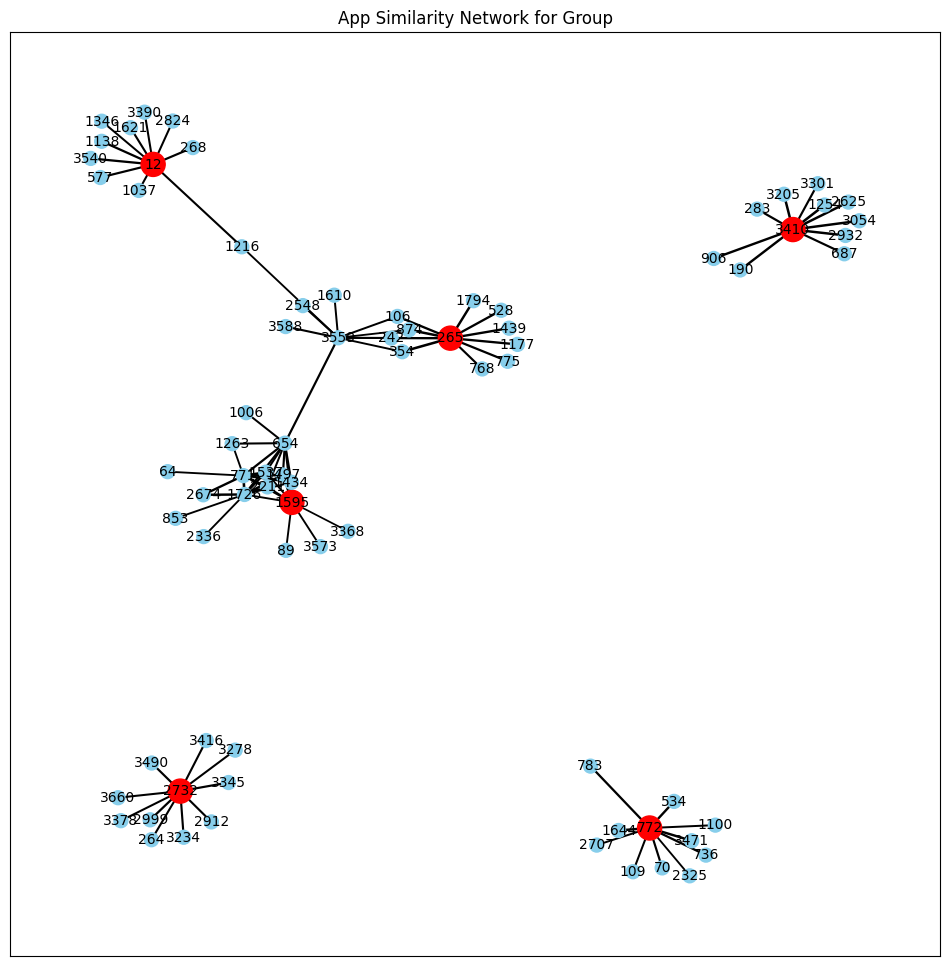

In [10]:
# 그룹 전체 데이터
group0_df = df_exploded

# 그룹 0에서 자주 등장하는 앱 확인
group0_app_counts = group0_df['app'].explode().value_counts().reset_index()
group0_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group0 = group0_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = df_exploded.groupby('adid')['app'].apply(list).tolist()

app_sequence = group0_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])
# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42)

# 그룹 0 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group0:
    G.add_node(app, color='red', size=300, seed=42)  # 그룹 2 상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='skyblue', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('App Similarity Network for Group')

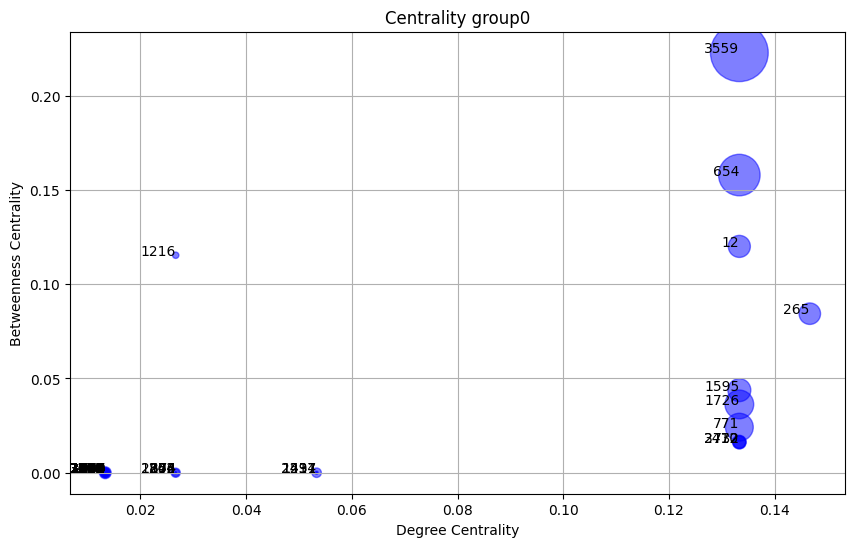

In [11]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 0.03 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='blue', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=10, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group0')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.show()


## 무관심 그룹

Text(0.5, 1.0, 'App Similarity Network for Group 0')

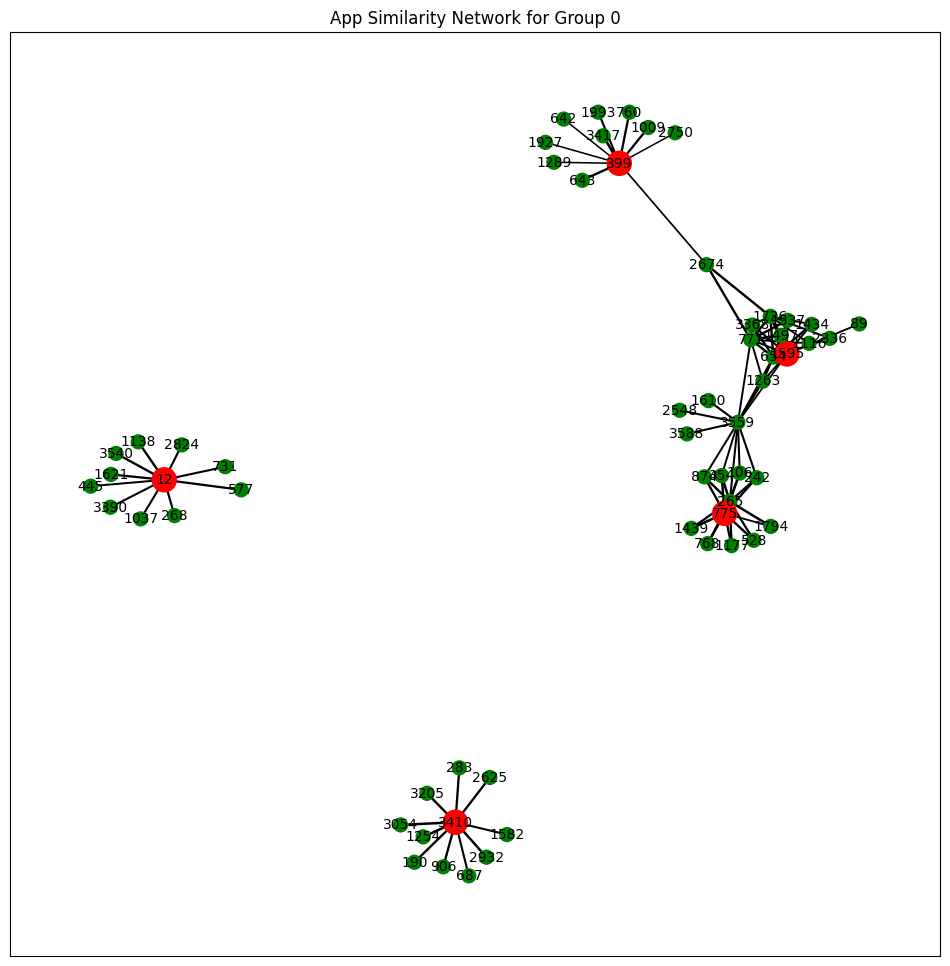

In [12]:
# 그룹 0 데이터 필터링
group0_df = df_exploded[df_exploded['group'] == '무관심']

# 그룹 0에서 자주 등장하는 앱 확인
group0_app_counts = group0_df['app'].explode().value_counts().reset_index()
group0_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group0 = group0_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = df_exploded.groupby('adid')['app'].apply(list).tolist()

app_sequence = group0_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])
# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42)

# 그룹 0 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group0:
    G.add_node(app, color='red', size=300, seed=42)  # 그룹 2 상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='green', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('App Similarity Network for Group 0')

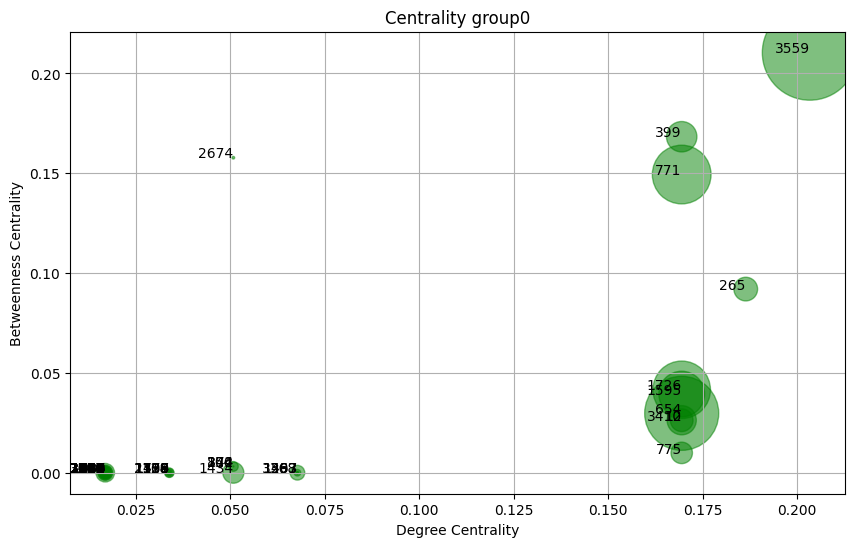

In [13]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 0.3 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='green', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=10, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group0')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.show()


## 클릭 후 이탈 그룹

Text(0.5, 1.0, 'App Similarity Network for Group 1')

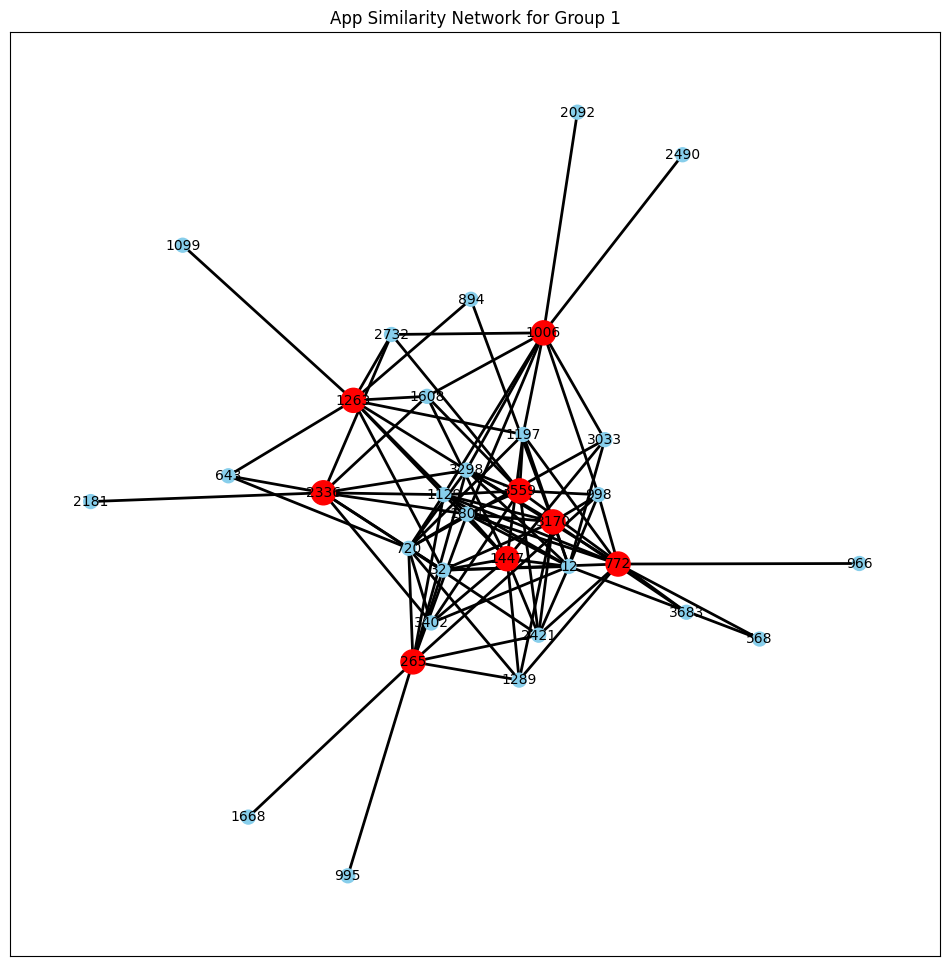

In [14]:
# 그룹 1 데이터 필터링
group1_df = df_exploded[df_exploded['group'] == '클릭 후 이탈']

# 그룹 1에서 자주 등장하는 앱 확인
group1_app_counts = group1_df['app'].explode().value_counts().reset_index()
group1_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group1 = group1_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = group1_df.groupby('adid')['app'].apply(list).tolist()

app_sequence = group1_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42, workers=1)

# 그룹 0 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group1:
    G.add_node(app, color='red', size=300, seed=42)  #상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='skyblue', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('App Similarity Network for Group 1')

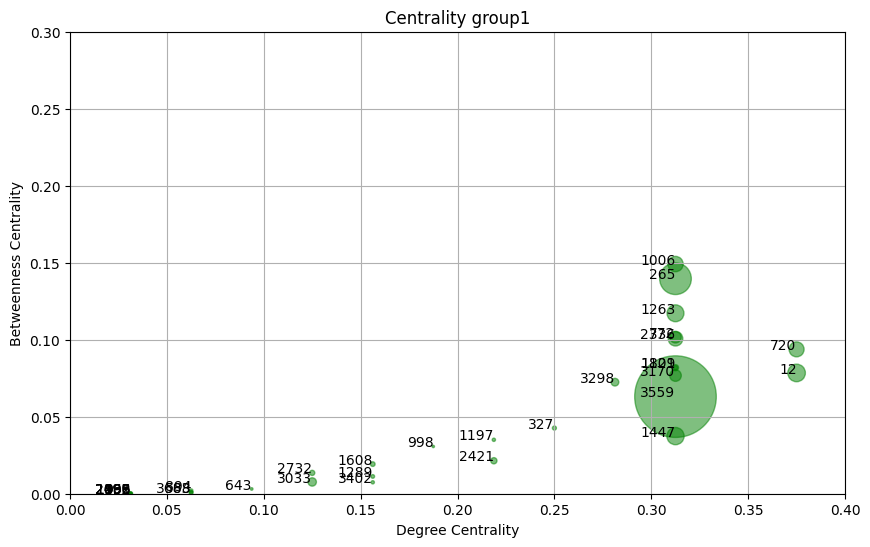

In [16]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 0.7 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='green', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=10, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group1')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.xlim(0, 0.4)
plt.ylim(0, 0.3)
plt.show()

In [650]:
# 특정 앱의 중심성 지표 추출
specific_app = '1726'
if specific_app in G.nodes():
    specific_degree = degree_centrality[specific_app]
    specific_betweenness = betweenness_centrality[specific_app]
    print(f"Degree Centrality for {specific_app}: {specific_degree}")
    print(f"Betweenness Centrality for {specific_app}: {specific_betweenness}")
else:
    print(f"App {specific_app} not found in the network.")

App 1726 not found in the network.


In [448]:
# 특정 앱과 유사한 앱 추출
import pandas as pd
from collections import Counter
from itertools import combinations
from gensim.models import Word2Vec

df1 = df.query("group == '클릭 후 이탈'")
# 특정 앱 설정
specific_app = '1447'

# 특정 앱과 함께 등장한 앱의 등장 횟수 계산
app_combinations = [comb for apps in df1['app'] for comb in combinations(apps, 2) if specific_app in comb]
app_counts = Counter(app for pair in app_combinations for app in pair if app != specific_app)

# 빈도수 데이터프레임 생성
app_counts_df = pd.DataFrame(app_counts.items(), columns=['app', 'count']).sort_values(by='count', ascending=False)

# 상위 30개 앱 추출
top_20_apps = app_counts_df.head(20)['app'].tolist()
print("Top 20 apps that frequently appear with specific app:")
print(top_20_apps)

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = df1.groupby('adid')['app'].apply(list).tolist()

# 특정 앱과 상위 30개 앱의 유사도 계산
similarities = []
for app in top_20_apps:
    if app in model.wv:
        similarity = model.wv.similarity(specific_app, app)
        similarities.append((app, similarity))

# 유사도 상위 10개 앱 추출
top_10_similar_apps = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

# 결과 출력
print("Top 10 similar apps with specific app:")
for app, similarity in top_10_similar_apps:
        print(f"App: {app}, {app_counts[app]}")

Top 20 apps that frequently appear with specific app:
['720', '3033', '3559', '265', '894', '1826', '1801', '1074', '2498', '2165', '424', '3298', '568', '1129', '949', '2948', '1626', '2421', '973', '775']
Top 10 similar apps with specific app:
App: 1129, 1
App: 1801, 4
App: 2421, 1
App: 3033, 17
App: 894, 5
App: 3298, 1
App: 568, 1
App: 720, 25
App: 1826, 4
App: 2498, 2


In [361]:
# 중심성 지표 표 시각화
results = []
for app in G.nodes():
    results.append({
        'app': app,
        '매개중심': betweenness_centrality.get(app, 0),
        '연결중심': degree_centrality.get(app, 0),
        'frequency': app_counts.get(app, 0)
    })

results_df = pd.DataFrame(results)
results_df = results_df[results_df['매개중심']>=0.06]
results_df = results_df[results_df['연결중심']>=0.2]
results_df 

,app,매개중심,연결중심,frequency
0,3559,0.063056,0.31250,4933
1,3298,0.072435,0.28125,44
4,1801,0.081853,0.31250,28
5,1129,0.081853,0.31250,13
11,265,0.139605,0.31250,743
15,720,0.093744,0.37500,167
17,12,0.078433,0.37500,229
21,1263,0.117173,0.31250,212
25,1006,0.149135,0.31250,175
28,2336,0.100667,0.31250,159


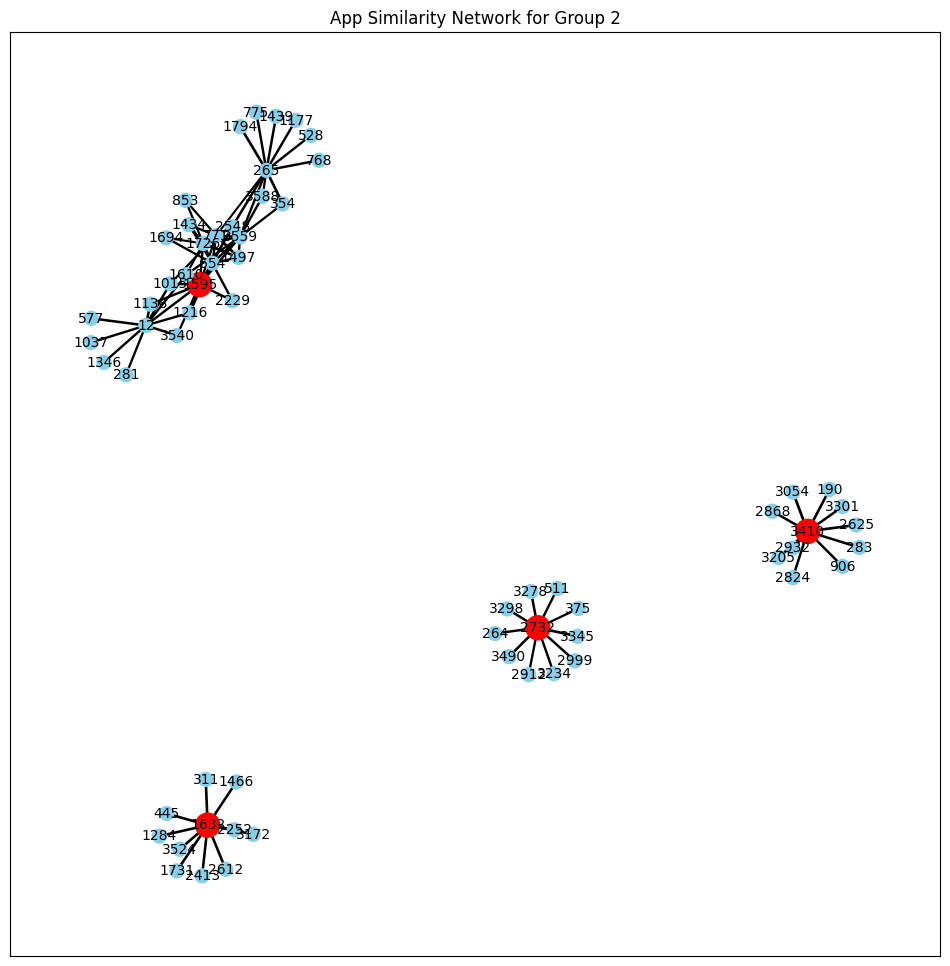

In [17]:
# 그룹 2 데이터 필터링
group2_df = df_exploded[df_exploded['group'] == '활동 후 이탈']

# 그룹 2에서 자주 등장하는 앱 확인
group2_app_counts = group2_df['app'].explode().value_counts().reset_index()
group2_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group2 = group2_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = group2_df.groupby('adid')['app'].apply(list).tolist()

app_sequence = group2_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42,workers=1)

# 그룹 2 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group2:
    G.add_node(app, color='red', size=300, seed=42)  # 그룹 2 상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='skyblue', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('App Similarity Network for Group 2')
plt.show()

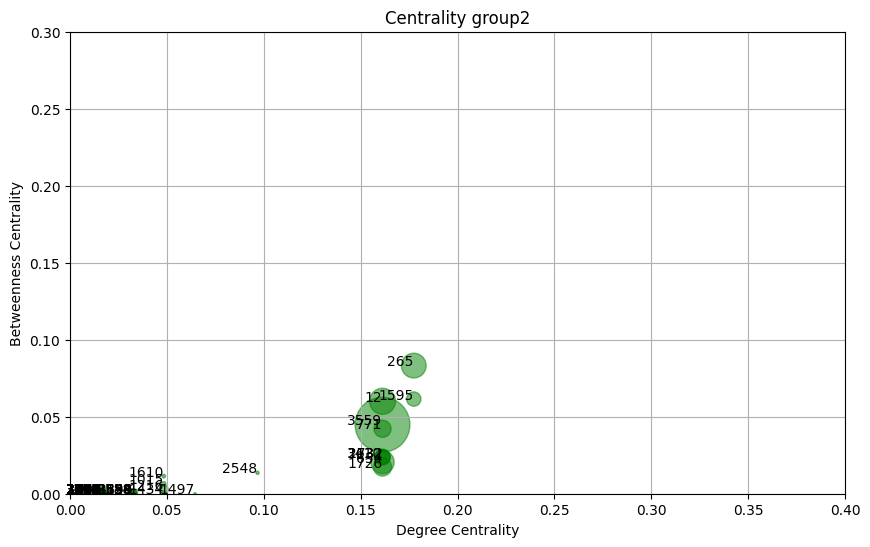

In [18]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 0.1 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='green', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=10, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group2')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.xlim(0, 0.4)
plt.ylim(0, 0.3)
plt.show()


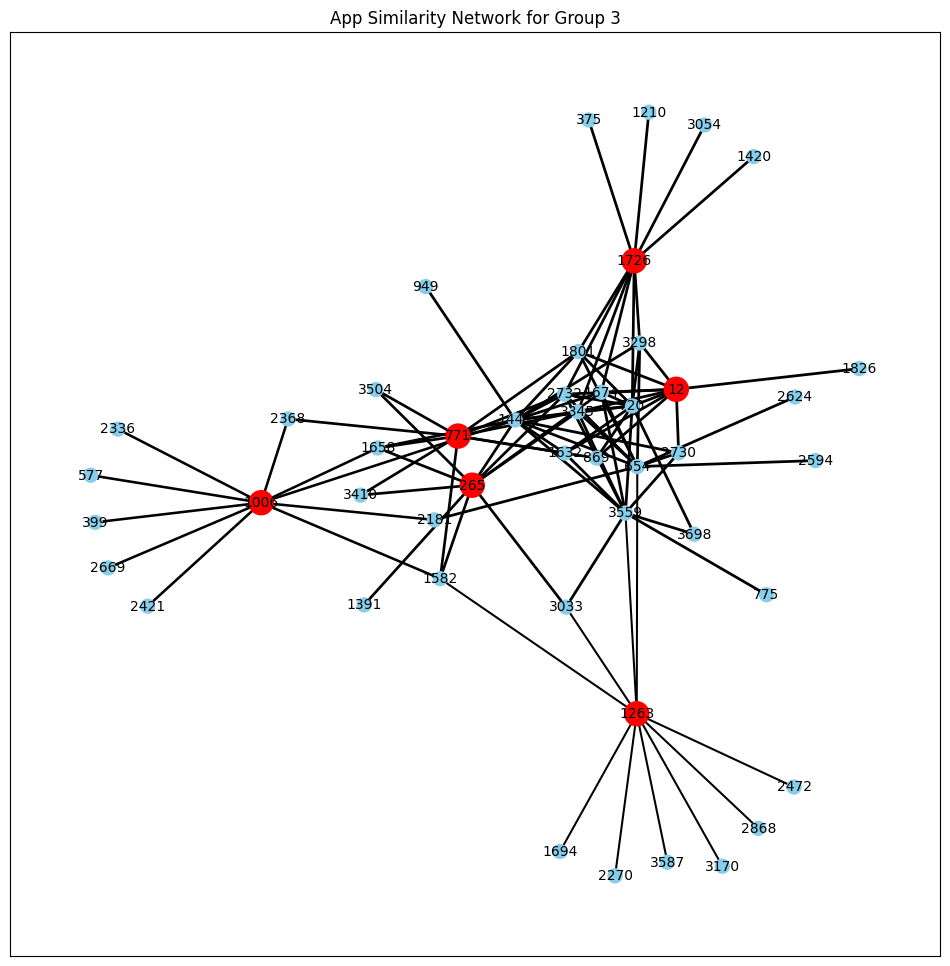

In [19]:
# 그룹 3 데이터 필터링
group3_df = df_exploded[df_exploded['group'] == '직접 전환']

# 그룹 3에서 자주 등장하는 앱 확인
group3_app_counts = group3_df['app'].explode().value_counts().reset_index()
group3_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group3 = group3_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = group3_df.groupby('adid')['app'].apply(list).tolist()

app_sequence = group3_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42,workers=1)

# 그룹 3 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group3:
    G.add_node(app, color='red', size=300, seed=42)  # 그룹 3 상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='skyblue', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('App Similarity Network for Group 3')
plt.show()

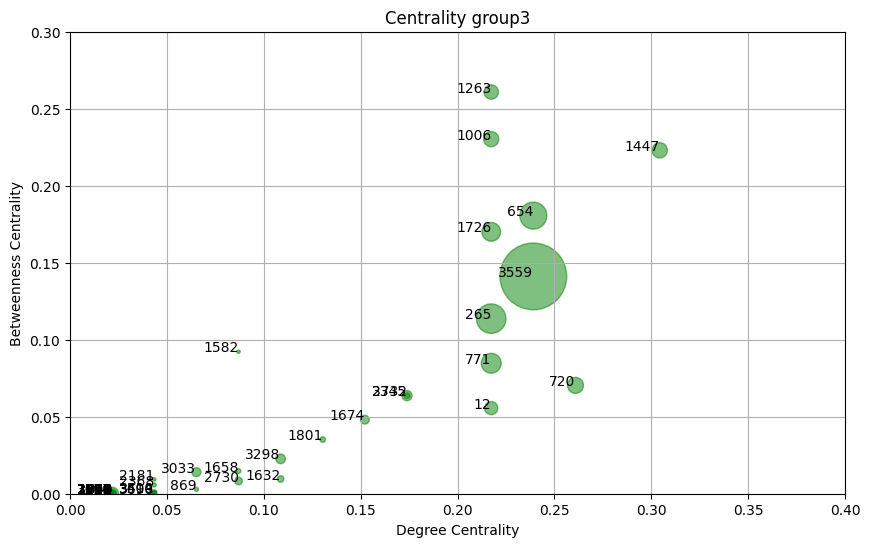

In [20]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 2 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='green', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=10, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group3')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.xlim(0, 0.4)
plt.ylim(0, 0.3)
plt.show()

In [21]:
# key app
results = []
for app in G.nodes():
    results.append({
        'app': app,
        '매개중심': betweenness_centrality.get(app, 0),
        '연결중심': degree_centrality.get(app, 0),
        'frequency': app_counts.get(app, 0)
    })

results_df = pd.DataFrame(results)
results_df = results_df[results_df['매개중심']>=0.1]
results_df = results_df[results_df['연결중심']>=0.2]
results_df.reset_index().drop(['index'], axis = 1)

,app,매개중심,연결중심,frequency
0,3559,0.141125,0.239130,1155
1,1447,0.223012,0.304348,61
2,265,0.113683,0.217391,226
3,654,0.180593,0.239130,190
4,1726,0.170036,0.217391,91
5,1006,0.230245,0.217391,60
6,1263,0.260835,0.217391,54


## 간접 전환 그룹

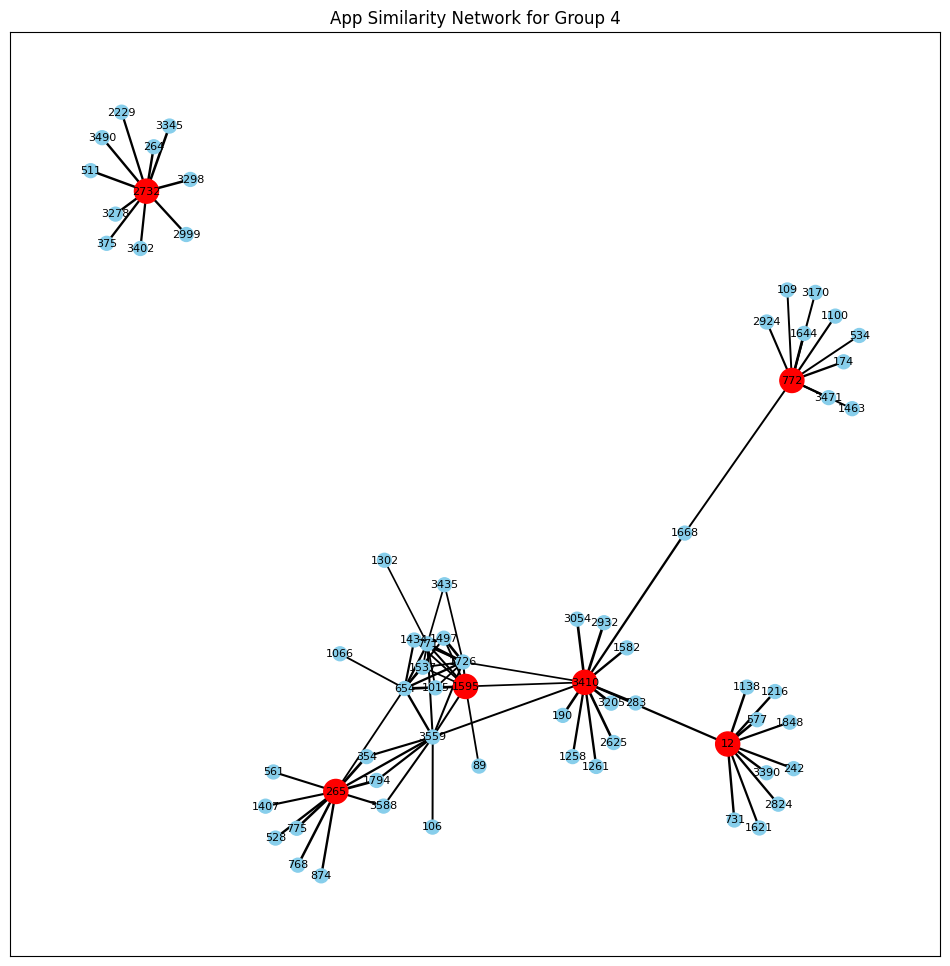

In [22]:
# 그룹 4 데이터 필터링
group4_df = df_exploded[df_exploded['group'] == '간접 전환']

# 그룹 4에서 자주 등장하는 앱 확인
group4_app_counts = group4_df['app'].explode().value_counts().reset_index()
group4_app_counts.columns = ['app', 'counts']

# 상위 10개 앱 추출
top_apps_group4 = group4_app_counts.head(10)['app'].tolist()

# 데이터를 고객(adid) 단위로 그룹화하여 리스트 형태로 변환
app_sequences = group4_df.groupby('adid')['app'].apply(list).tolist()

app_sequence = group4_df['app'].apply(lambda x: x.split()).tolist()

# 앱 등장 빈도 계산
app_counts = Counter([app for sublist in app_sequence for app in sublist])

# Word2Vec 모델 학습
model = Word2Vec(app_sequences, vector_size=100, window=5, min_count=1, sg=1, seed=42,workers=1)

# 그룹 3 상위 앱들과 유사한 앱 찾기 및 네트워크 생성
G = nx.Graph(seed=42)

for app in top_apps_group4:
    G.add_node(app, color='red', size=300)  # 그룹 2 상위 앱은 빨간색
    similar_apps = model.wv.most_similar(app, topn=10)
    for sim_app, similarity in similar_apps:
        G.add_node(sim_app, color='skyblue', size=100, seed=42)  # 유사한 앱은 파란색
        G.add_edge(app, sim_app, weight=similarity, seed=42)

# 노드 색상 및 크기 설정
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# 네트워크 시각화
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in edge_weights])
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('App Similarity Network for Group 4')
plt.show()

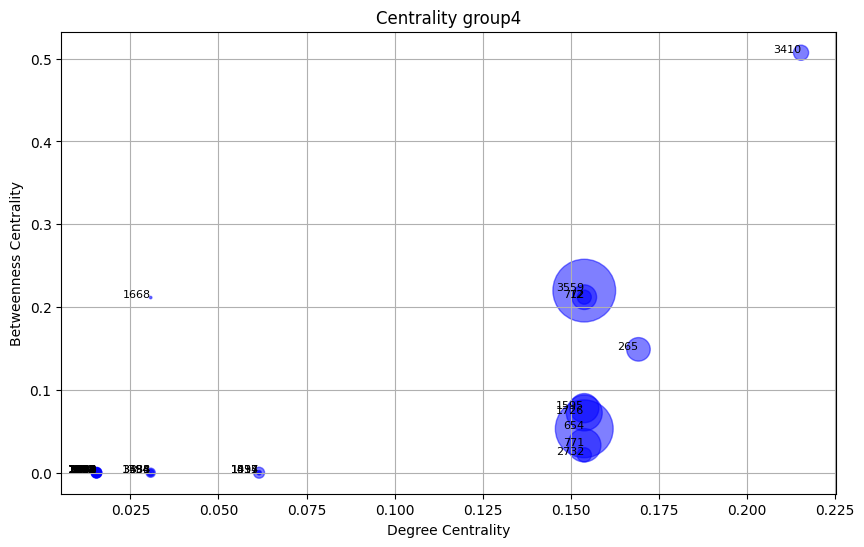

In [23]:
# 중심성 지표 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Degree Centrality와 Betweenness Centrality 값을 리스트로 변환
degree_values = [degree_centrality[node] for node in G.nodes()]
betweenness_values = [betweenness_centrality[node] for node in G.nodes()]
app_labels = list(G.nodes())

# 각 노드의 등장 빈도 계산
node_sizes = [app_counts[node] * 0.1 for node in G.nodes()]  # 빈도에 따라 크기 조정

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, s=node_sizes, color='blue', alpha=0.5)

# 라벨링 (앱 이름 표시)
for i, label in enumerate(app_labels):
    plt.text(degree_values[i], betweenness_values[i], label, fontsize=8, ha='right')

# 그래프 제목 및 축 라벨 설정
plt.title('Centrality group4')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.show()